In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F  
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import cv2
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import sys
import time
import timm
from PIL import Image
from timm import create_model
import os
import warnings


In [2]:
# For reproduce the result
torch.manual_seed(1220)
random.seed(1220)
np.random.seed(1220)

In [3]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)
print("You are using PyTorch version: %s" % torch.__version__)

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# define class names
classes = ('Diagonal','Diagonal_large','Horizontal', 'Horizontal_large', 'spalling-like_cracks','Vertical','Vertical_large', 'Web', 'Web_large','X-shape')

path_dataset = 'datasets/crack_classification/resized/wall_resize'

You are using device: cpu
You are using PyTorch version: 2.7.1+cpu


In [4]:
def load_dataset(path_dataset):
    transform_train = transforms.Compose([
        transforms.Resize([224, 224]),   # Resize first
        transforms.RandomChoice([
        transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        #transforms.RandomRotation(degrees=15),
]),

        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Data transformations for testing
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # load custom dataset
    full_dataset = torchvision.datasets.ImageFolder(
        root=path_dataset,
        transform=transform_train
    )
    
    # Split dataset into training and validation sets (8:2)
    dataset_size = len(full_dataset)
    train_size = int(0.9 * dataset_size)
    val_size = dataset_size - train_size
    
    trainset, valset = random_split(full_dataset, [train_size, val_size])
    
    # Create data loaders
    trainloader = DataLoader(
        trainset, batch_size=32, shuffle=True, num_workers=2
    )
    
    valloader = DataLoader(
        valset, batch_size=25, shuffle=False, num_workers=2
    )
    
    
    # Map folder names to class names
    class_map = {i: full_dataset.classes[i] for i in range(len(full_dataset.classes))}
    print(f"Dataset classes: {class_map}")

    global classes
    if len(full_dataset.classes) == len(classes):
        print("Using predefined class names")
    else:
        print("Using classes from dataset folder structure")
        classes = full_dataset.classes
    
    return trainloader, valloader

# Load dataset
trainloader, valloader = load_dataset(path_dataset)

Dataset classes: {0: 'Diagonal', 1: 'Diagonal_large', 2: 'Horizontal', 3: 'Horizontal_large', 4: 'Vertical', 5: 'Vertical_large', 6: 'Web', 7: 'Web_large', 8: 'X-shape', 9: 'spalling-like_cracks'}
Using predefined class names


In [5]:
class CrackClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(CrackClassifier, self).__init__()
        self.model = timm.create_model("vit_base_patch16_224", pretrained=True)
        self.model.head = nn.Linear(self.model.head.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

model = CrackClassifier(num_classes=10).to(device)

In [6]:
def train(model,trainloader,valloader,max_epochs=50,patience=5,min_delta=0.05):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr= 0.0001, weight_decay = 1e-2) 
    
    # Reduce LR on plateau of validation loss
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(max_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(enumerate(trainloader), total=len(trainloader), leave=True)

        for i, data in loop:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

            loop.set_description(f"Epoch [{epoch+1}/{max_epochs}]")
            loop.set_postfix(loss=running_loss/(i+1), accuracy=100.*correct/total)

        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_acc = 100. * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(valloader)
        epoch_val_acc = 100. * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        scheduler.step(epoch_val_loss)  # Updating Learning Rate scheduler

        print(f"\nEpoch {epoch+1}/{max_epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.2f}%")
        print(f"Val   Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.2f}%")
        print("-" * 60)

        # Implementing early stopping in training so that training can be stop when overfitting occurs
        if epoch_val_loss + min_delta < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            best_model_wts = model.state_dict()  # Save best weights
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epochs.")

        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

    print("Finished Training")
    model.load_state_dict(best_model_wts)  # Load best weights
    return model, train_losses, train_accuracies, val_losses, val_accuracies


In [7]:
def Save_Model():
    torch.save(model.state_dict(), 'model_crack.pth')
    print("Model saved successfully!")
    return

def Load_Model():
    model.load_state_dict(torch.load('model_crack.pth'))
    model.eval()
    print("Model loaded successfully!")
    return

In [8]:
print("Starting training...")
trained_model, train_losses, train_accuracies, val_losses, val_accuracies = train(
    model, trainloader, valloader
)

Starting training...


Epoch [1/50]: 100%|██████████| 25/25 [05:27<00:00, 13.08s/it, accuracy=39, loss=1.77]  



Epoch 1/50
Train Loss: 1.7735, Acc: 39.01%
Val   Loss: 1.6425, Acc: 44.32%
------------------------------------------------------------


Epoch [2/50]: 100%|██████████| 25/25 [06:20<00:00, 15.22s/it, accuracy=62.3, loss=1.07]



Epoch 2/50
Train Loss: 1.0748, Acc: 62.26%
Val   Loss: 0.9882, Acc: 62.50%
------------------------------------------------------------


Epoch [3/50]: 100%|██████████| 25/25 [07:04<00:00, 17.00s/it, accuracy=76.7, loss=0.636]



Epoch 3/50
Train Loss: 0.6356, Acc: 76.75%
Val   Loss: 1.1540, Acc: 59.09%
------------------------------------------------------------
No improvement for 1 epochs.


Epoch [4/50]: 100%|██████████| 25/25 [07:11<00:00, 17.25s/it, accuracy=85.1, loss=0.419]



Epoch 4/50
Train Loss: 0.4187, Acc: 85.13%
Val   Loss: 1.4104, Acc: 62.50%
------------------------------------------------------------
No improvement for 2 epochs.


Epoch [5/50]: 100%|██████████| 25/25 [06:35<00:00, 15.81s/it, accuracy=88.3, loss=0.325]



Epoch 5/50
Train Loss: 0.3252, Acc: 88.31%
Val   Loss: 1.3218, Acc: 62.50%
------------------------------------------------------------
No improvement for 3 epochs.


Epoch [6/50]: 100%|██████████| 25/25 [07:22<00:00, 17.71s/it, accuracy=90.7, loss=0.236]



Epoch 6/50
Train Loss: 0.2362, Acc: 90.72%
Val   Loss: 1.5917, Acc: 63.64%
------------------------------------------------------------
No improvement for 4 epochs.


Epoch [7/50]: 100%|██████████| 25/25 [07:23<00:00, 17.74s/it, accuracy=95.2, loss=0.145]



Epoch 7/50
Train Loss: 0.1451, Acc: 95.17%
Val   Loss: 1.3804, Acc: 62.50%
------------------------------------------------------------
No improvement for 5 epochs.
Early stopping triggered!
Finished Training


In [9]:
def evaluate(model, valloader):

    model.eval()
    correct = 0
    total = 0
    
    # Initialize lists for per-class accuracy
    num_classes = len(classes)
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    
    # Initialize confusion matrix
    confusion_matrix = torch.zeros(num_classes, num_classes)
    
    with torch.no_grad():
        for data in tqdm(valloader, desc="Evaluating"):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Calculate per-class accuracy
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
                
                # Update confusion matrix
                confusion_matrix[label, predicted[i]] += 1

    overall_accuracy = 100 * correct / total
    print(f'Overall Accuracy: {overall_accuracy:.2f}%')

    
    return class_correct, class_total, confusion_matrix

In [10]:
print("Starting evaluating...")
class_correct, class_total, confusion_matrix = evaluate(trained_model, valloader)

Starting evaluating...


Evaluating: 100%|██████████| 4/4 [00:26<00:00,  6.63s/it]

Overall Accuracy: 57.95%


In [11]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):

    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    fig.savefig('training_metrics.png')
    print("Training metrics plot saved as 'training_metrics.png'")
    return

In [12]:
def plot_evaluation_metrics(class_correct, class_total, confusion_matrix):

    num_classes = len(classes)
    
    # Calculate accuracies and identify valid classes
    accuracies = []
    valid_classes = []
    
    print("\nPer-class Accuracy:")
    print("-" * 50)
    for i in range(num_classes):
        if class_total[i] > 0:  # Avoid division by zero
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'{classes[i]}: {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')
            accuracies.append(accuracy)
            valid_classes.append(classes[i])
        else:
            print(f'{classes[i]}: No samples')
    
    # Plot per-class accuracy as a bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(valid_classes, accuracies, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.title('Per-class Accuracy')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('per_class_accuracy.png')
    plt.show()
    
    # Normalize confusion matrix by row (true labels) and plot
    normalized_confusion_matrix = confusion_matrix.clone()  # Create a copy to avoid modifying the original
    for i in range(num_classes):
        if normalized_confusion_matrix[i].sum() > 0:
            normalized_confusion_matrix[i] = normalized_confusion_matrix[i] / normalized_confusion_matrix[i].sum()
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(normalized_confusion_matrix.cpu().numpy(), interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
   
    thresh = normalized_confusion_matrix.cpu().numpy().max() / 2.0
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, f'{normalized_confusion_matrix[i, j]:.2f}',
                     horizontalalignment="center",
                     color="white" if normalized_confusion_matrix[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    return

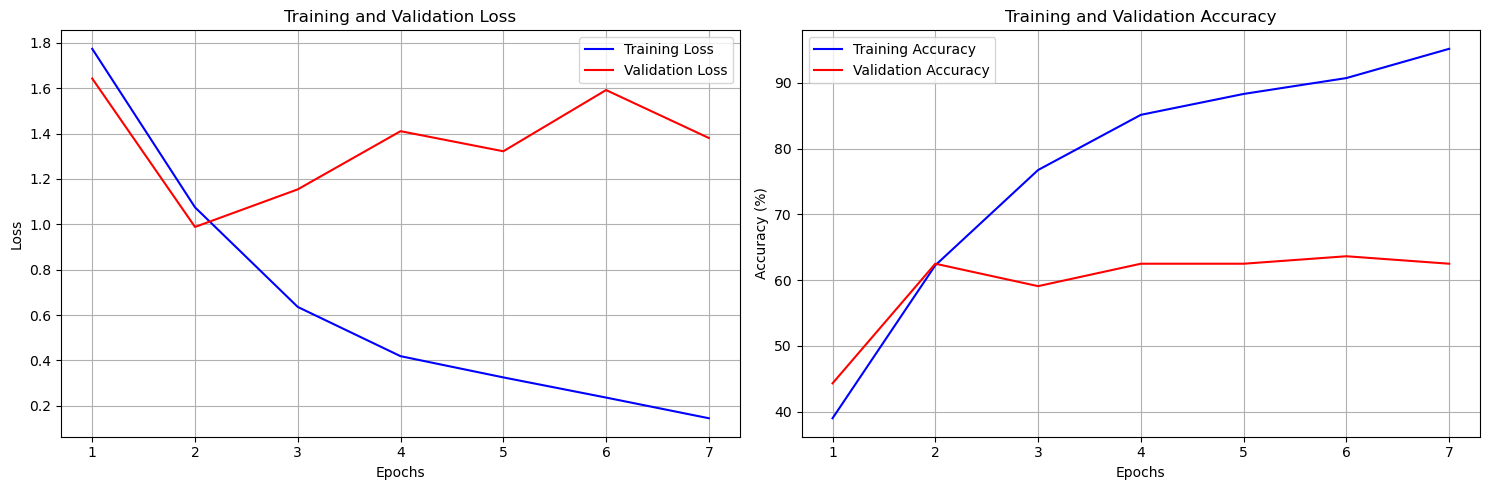

Training metrics plot saved as 'training_metrics.png'


In [13]:
plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies)


Per-class Accuracy:
--------------------------------------------------
Diagonal: 61.90% (13/21)
Diagonal_large: 33.33% (1/3)
Horizontal: 85.71% (12/14)
Horizontal_large: 75.00% (3/4)
spalling-like_cracks: 73.33% (11/15)
Vertical: 20.00% (1/5)
Vertical_large: 45.45% (5/11)
Web: 0.00% (0/4)
Web_large: 50.00% (3/6)
X-shape: 40.00% (2/5)


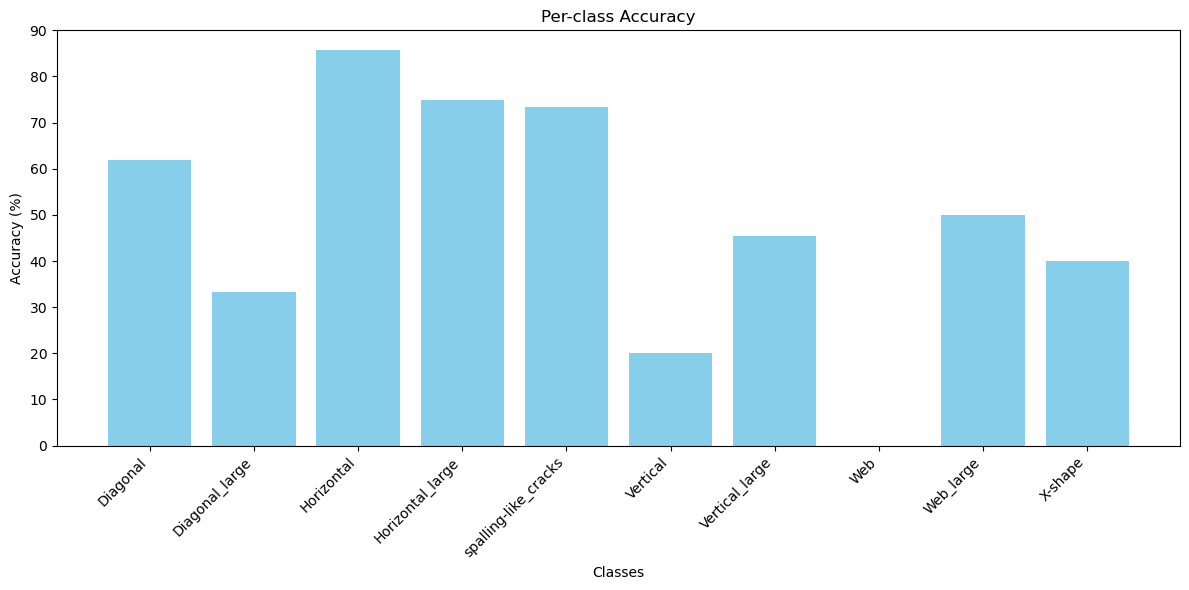

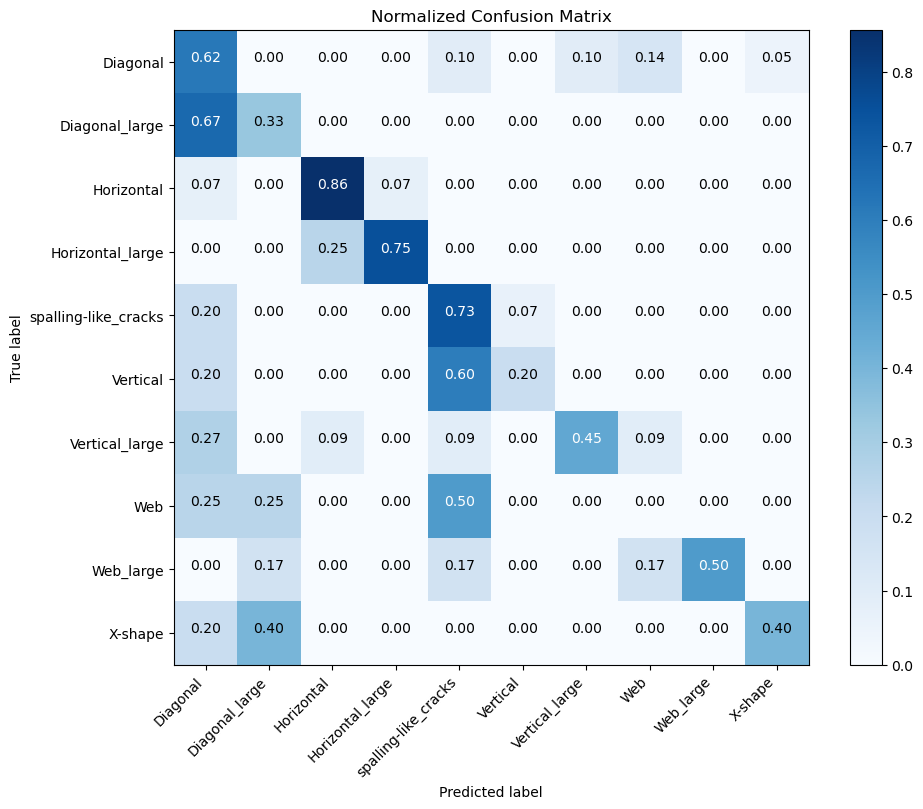

In [14]:
plot_evaluation_metrics(class_correct, class_total, confusion_matrix)

In [15]:
Save_Model()

Model saved successfully!


In [16]:
from ultralytics import YOLO

In [17]:
# Load Dataset
damage_detection_dataset = "datasets/damage_detection/3class/for_training/datasets_3class_wall_shuffled/"

with open("datasets/damage_detection/3class/labelList.txt", "r") as f:
    label_list = [line.strip() for line in f.readlines()]

In [18]:
from ultralytics import YOLO
# ---------------- Load YOLOv9 ---------------- #
yolo_model = YOLO("runs/detect/train/weights/best.pt")  # path to your trained weights

# Define YOLO class names based on your training (change accordingly)
yolo_class_names = ['Exposed rebar', 'Crack', 'Spalling']  # <- Update this as per your training labels

# ---------------- Load Crack Type Classifier (ViT or ResNet) ---------------- #
class CrackClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(CrackClassifier, self).__init__()
        self.model = create_model("vit_base_patch16_224", pretrained=False, num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

classifier = CrackClassifier(num_classes=10)
classifier.load_state_dict(torch.load("model_crack.pth", map_location=torch.device("cpu")))
classifier.eval()

# ---------------- Image Preprocessing ---------------- #
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

crack_class_names = ['Diagonal','Diagonal_large','Horizontal', 'Horizontal_large', 'spalling-like_cracks','Vertical','Vertical_large', 'Web', 'Web_large','X-shape']

# ---------------- Detection + Classification + Visualization ---------------- #
def detect_and_classify_all(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    draw_image = image.copy()

    results = yolo_model(image_rgb)[0]
    boxes = results.boxes.xyxy.cpu().numpy().astype(int)
    class_ids = results.boxes.cls.cpu().numpy().astype(int)

    for j, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        class_id = class_ids[j]
        detected_label = yolo_class_names[class_id]
        cropped = image_rgb[y1:y2, x1:x2]

        if cropped.size == 0:
            continue

        # Default label is the YOLO detection label
        label = detected_label.capitalize()

        # If it's a crack, further classify it
        if detected_label == 'Crack':
            img_pil = Image.fromarray(cropped)
            input_tensor = transform(img_pil).unsqueeze(0)
            with torch.no_grad():
                output = classifier(input_tensor)
                pred_class = torch.argmax(output, dim=1).item()
                crack_type = crack_class_names[pred_class]
                label = f"Crack: {crack_type}"

        # Draw bounding box and label
        cv2.rectangle(draw_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(draw_image, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (36, 255, 12), 2)

        print(f"[{os.path.basename(image_path)}] Detected {label} at [{x1}, {y1}, {x2}, {y2}]")

    # Show results with matplotlib
    plt.figure(figsize=(12, 10))
    plt.imshow(cv2.cvtColor(draw_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(os.path.basename(image_path))
    plt.show()

    # Save image
    os.makedirs("results", exist_ok=True)
    out_path = os.path.join("results", os.path.basename(image_path))
    cv2.imwrite(out_path, draw_image)

# ---------------- Process All Test Images ---------------- #
test_folder = "datasets/test_data/beam"
for filename in os.listdir(test_folder):
    if filename.lower().endswith(('.jpg', '.png')):
        detect_and_classify_all(os.path.join(test_folder, filename))

FileNotFoundError: [Errno 2] No such file or directory: 'runs\\detect\\train\\weights\\best.pt'

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define same transform used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Match training size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root="datasets\damage_classification_forTrain\wall_damage", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
# Define the exact architecture
def get_densenet201_model(num_classes=3):
    model = models.densenet201(weights="IMAGENET1K_V1")  # pretrained=False to avoid mismatch
    for param in model.parameters():
        param.requires_grad = False  
    for param in model.features.denseblock4.parameters():
        param.requires_grad = True
    for param in model.features.transition3.parameters():
        param.requires_grad = True
    for param in model.features.norm5.parameters():
        param.requires_grad = True

    num_features = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Linear(num_features, 1024),
        nn.ReLU(),
        nn.Dropout(0.7),
        nn.Linear(1024, num_classes)
    )
    return model

# Load model and weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_densenet201_model(num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(25):  # or however many you want
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

torch.save(model.state_dict(), "model.pth")
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()


In [ ]:
import os
from PIL import Image

def predict_folder(folder_path):
    predictions = {}

    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path).convert("RGB")
            input_tensor = transform(image).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(input_tensor)
                pred_class = output.argmax(dim=1).item()

            label_map = {0: "18", 1: "19", 2: "20"}  # Modify if different
            predictions[filename] = label_map[pred_class]

    return predictions

folder_path = 'datasets/test_data/wall'
results = predict_folder(folder_path)

for img_name, pred_label in results.items():
    print(f"{img_name} => {pred_label}")


In [ ]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ----------------- Load Models ----------------- #

# YOLO for damage detection
yolo_model = YOLO("runs/detect/train/weights/best.pt")
yolo_class_names = ['Exposed rebar', 'Crack', 'Spalling']

# Crack classification (ViT)
from timm import create_model

class CrackClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(CrackClassifier, self).__init__()
        self.model = create_model("vit_base_patch16_224", pretrained=False, num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

crack_model = CrackClassifier(num_classes=10)
crack_model.load_state_dict(torch.load("model_crack.pth", map_location=torch.device("cpu")))
crack_model.eval()

crack_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
crack_class_names = ['Diagonal','Diagonal_large','Horizontal', 'Horizontal_large', 'spalling-like_cracks','Vertical','Vertical_large', 'Web', 'Web_large','X-shape']

# Damage classification (DenseNet)
from torchvision.models import densenet201

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

damage_model = densenet201()
for param in damage_model.parameters():
    param.requires_grad = False
for param in damage_model.features.denseblock4.parameters():
    param.requires_grad = True
for param in damage_model.features.transition3.parameters():
    param.requires_grad = True
for param in damage_model.features.norm5.parameters():
    param.requires_grad = True

damage_model.classifier = nn.Sequential(
    nn.Linear(damage_model.classifier.in_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.7),
    nn.Linear(1024, 3)
)
damage_model.load_state_dict(torch.load("model.pth", map_location=device))
damage_model.eval().to(device)

damage_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
damage_label_map = {0: "18", 1: "19", 2: "20"}

# ----------------- Unified Function ----------------- #
def process_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    draw_image = image.copy()
    basename = os.path.basename(image_path)

    # Step 1: YOLO detection
    results = yolo_model(image_rgb)[0]
    boxes = results.boxes.xyxy.cpu().numpy().astype(int)
    class_ids = results.boxes.cls.cpu().numpy().astype(int)

    for j, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        class_id = class_ids[j]
        label = yolo_class_names[class_id]
        cropped = image_rgb[y1:y2, x1:x2]

        if cropped.size == 0:
            continue

        # Step 2: Crack classification
        if label == 'Crack':
            img_pil = Image.fromarray(cropped)
            input_tensor = crack_transform(img_pil).unsqueeze(0)
            with torch.no_grad():
                output = crack_model(input_tensor)
                crack_pred = torch.argmax(output, dim=1).item()
                crack_label = crack_class_names[crack_pred]
                label = f"Crack: {crack_label}"

        # Draw
        cv2.rectangle(draw_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(draw_image, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (36, 255, 12), 2)

        print(f"[{basename}] Detected {label} at [{x1}, {y1}, {x2}, {y2}]")

    # Step 3: Whole-image damage classification
    image_pil = Image.fromarray(image_rgb)
    input_tensor = damage_transform(image_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        output = damage_model(input_tensor)
        damage_pred = torch.argmax(output, dim=1).item()
        damage_label = damage_label_map[damage_pred]

    print(f"[{basename}] Predicted Damage Class: {damage_label}")

    # Show result
    plt.figure(figsize=(12, 10))
    plt.imshow(cv2.cvtColor(draw_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"{basename} - Damage Class: {damage_label}")
    plt.show()

    # Save result
    os.makedirs("results", exist_ok=True)
    out_path = os.path.join("results", basename)
    cv2.imwrite(out_path, draw_image)

# ----------------- Run on Folder ----------------- #
test_folder = "datasets/test_data/beam"
for filename in sorted(os.listdir(test_folder), key=lambda x: int(os.path.splitext(x)[0])):
    if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
        process_image(os.path.join(test_folder, filename))


In [ ]:


import os
import cv2
import torch
import csv
from PIL import Image
from torchvision import transforms
from torchvision.models import densenet201
from timm import create_model
import torch.nn as nn
from ultralytics import YOLO

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------- Load Models ----------------- #
# YOLO for damage detection (lower confidence threshold)
yolo_model = YOLO("runs/detect/train/weights/best.pt")
yolo_class_names = ['Exposed rebar', 'Crack', 'Spalling']

# Crack classifier (ViT)
class CrackClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = create_model(
            "vit_base_patch16_224", pretrained=False, num_classes=num_classes)
    def forward(self, x):
        return self.model(x)

crack_model = CrackClassifier(num_classes=10).to(device)
crack_model.load_state_dict(torch.load("model_crack.pth", map_location=device))
crack_model.eval()

crack_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
crack_class_names = [
    'Diagonal','Diagonal_large','Horizontal','Horizontal_large',
    'spalling-like_cracks','Vertical','Vertical_large','Web','Web_large','X-shape'
]

# Damage classifier (DenseNet)
damage_model = densenet201()
for param in damage_model.parameters(): param.requires_grad = False
for param in damage_model.features.denseblock4.parameters(): param.requires_grad = True
for param in damage_model.features.transition3.parameters(): param.requires_grad = True
for param in damage_model.features.norm5.parameters(): param.requires_grad = True

damage_model.classifier = nn.Sequential(
    nn.Linear(damage_model.classifier.in_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.7),
    nn.Linear(1024, 3)
)
damage_model.load_state_dict(torch.load("model.pth", map_location=device))
damage_model.eval().to(device)

damage_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
damage_label_map = {0: 18, 1: 19, 2: 20}

# ----------------- Mapping Function ----------------- #
def map_crack_to_label(crack_type, damage_label):
    if crack_type == 'spalling-like_cracks':
        # Class A spalling, Class C small cracks
        return 2 if damage_label == 18 else (10 if damage_label == 20 else None)
    if crack_type == 'X-shape' and damage_label == 19:
        return 3
    if crack_type in ('Diagonal','Diagonal_large'):
        return 4 if damage_label == 19 else 5
    if crack_type in ('Vertical','Vertical_large'):
        return 6 if damage_label == 19 else 7
    if crack_type in ('Horizontal','Horizontal_large'):
        return 8 if damage_label == 19 else 9
    if crack_type in ('Web','Web_large') and damage_label == 20:
        return 10
    return None

# ----------------- Helper for TTA ----------------- #
def get_sublabels(image_rgb, damage_label):
    sublabels = set()
    res = yolo_model(image_rgb, conf=0.25)[0]
    boxes = res.boxes.xyxy.cpu().numpy().astype(int)
    cls_ids = res.boxes.cls.cpu().numpy().astype(int)
    for box, cid in zip(boxes, cls_ids):
        cls = yolo_class_names[int(cid)]
        x1, y1, x2, y2 = box
        crop = image_rgb[y1:y2, x1:x2]
        if crop.size == 0: continue
        if damage_label == 18:
            if cls == 'Exposed rebar': sublabels.add(0)
            if cls == 'Spalling': sublabels.add(2)
            continue
        if cls == 'Crack':
            img = Image.fromarray(crop)
            ct = crack_transform(img).unsqueeze(0).to(device)
            with torch.no_grad(): c_out = crack_model(ct)
            c_pred = c_out.argmax(dim=1).item()
            c_type = crack_class_names[c_pred]
            lbl = map_crack_to_label(c_type, damage_label)
            if lbl is not None: sublabels.add(lbl)
    return sublabels

# ----------------- Inference & CSV with TTA ----------------- #
csv_output = []

def process_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_id = int(os.path.splitext(os.path.basename(image_path))[0])

    # Damage classification
    pil = Image.fromarray(image_rgb)
    inp = damage_transform(pil).unsqueeze(0).to(device)
    with torch.no_grad(): d_out = damage_model(inp)
    damage_label = damage_label_map[d_out.argmax(dim=1).item()]

    # TTA: original + flipped
    sub1 = get_sublabels(image_rgb, damage_label)
    flipped = cv2.flip(image_rgb, 1)
    sub2 = get_sublabels(flipped, damage_label)
    sublabels = sub1.union(sub2)

    # Fallback if empty
    if not sublabels:
        sublabels.add(0 if damage_label == 18 else (4 if damage_label == 19 else 1))

    labels = [damage_label] + sorted(sublabels)
    csv_output.append([image_id] + labels)
    print(f"[{image_id}] => {labels}")

# Run and save
folder = "datasets/test_data/wall"
for fn in sorted(os.listdir(folder), key=lambda x: int(os.path.splitext(x)[0])):
    if fn.lower().endswith(('.jpg','.png','.jpeg')):
        process_image(os.path.join(folder, fn))
with open('datasets/test_data/wall.csv','w',newline='') as f:
    w = csv.writer(f)
    w.writerow(["ID","class"])
    for row in csv_output: w.writerow([row[0], ",".join(map(str,row[1:]))])
